In [76]:
import os
from zipfile import ZipFile

jetson_extract_path = "./analysis/jetson/metrics"
server_extract_path = "./analysis/server/metrics"

jetson_metrics_dir = "analysis/jetson/metrics/"
server_metrics_dir = "analysis/server/metrics/"

jetson_dataframes = {}
server_dataframes = {}

def init(extract_path, type):

    if not os.path.exists(extract_path):
        os.makedirs(extract_path)

    if not os.listdir(extract_path):
        archive_path = f"results/metrics/{type}.zip"

        with ZipFile(archive_path, "r") as file:
            file.extractall(extract_path)
            
init(jetson_extract_path, "jetson")
init(server_extract_path, "server")

In [77]:
import pandas as pd
import os

def populate_dataframes(directory, df_dict):
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".csv"):
            training_type = filename.split("-")[2].split(".")[0]
            df_dict[training_type] = pd.read_csv(
                directory + filename
            )
            
populate_dataframes(jetson_metrics_dir, jetson_dataframes)
populate_dataframes(server_metrics_dir, server_dataframes)

Jetson Execution Metrics


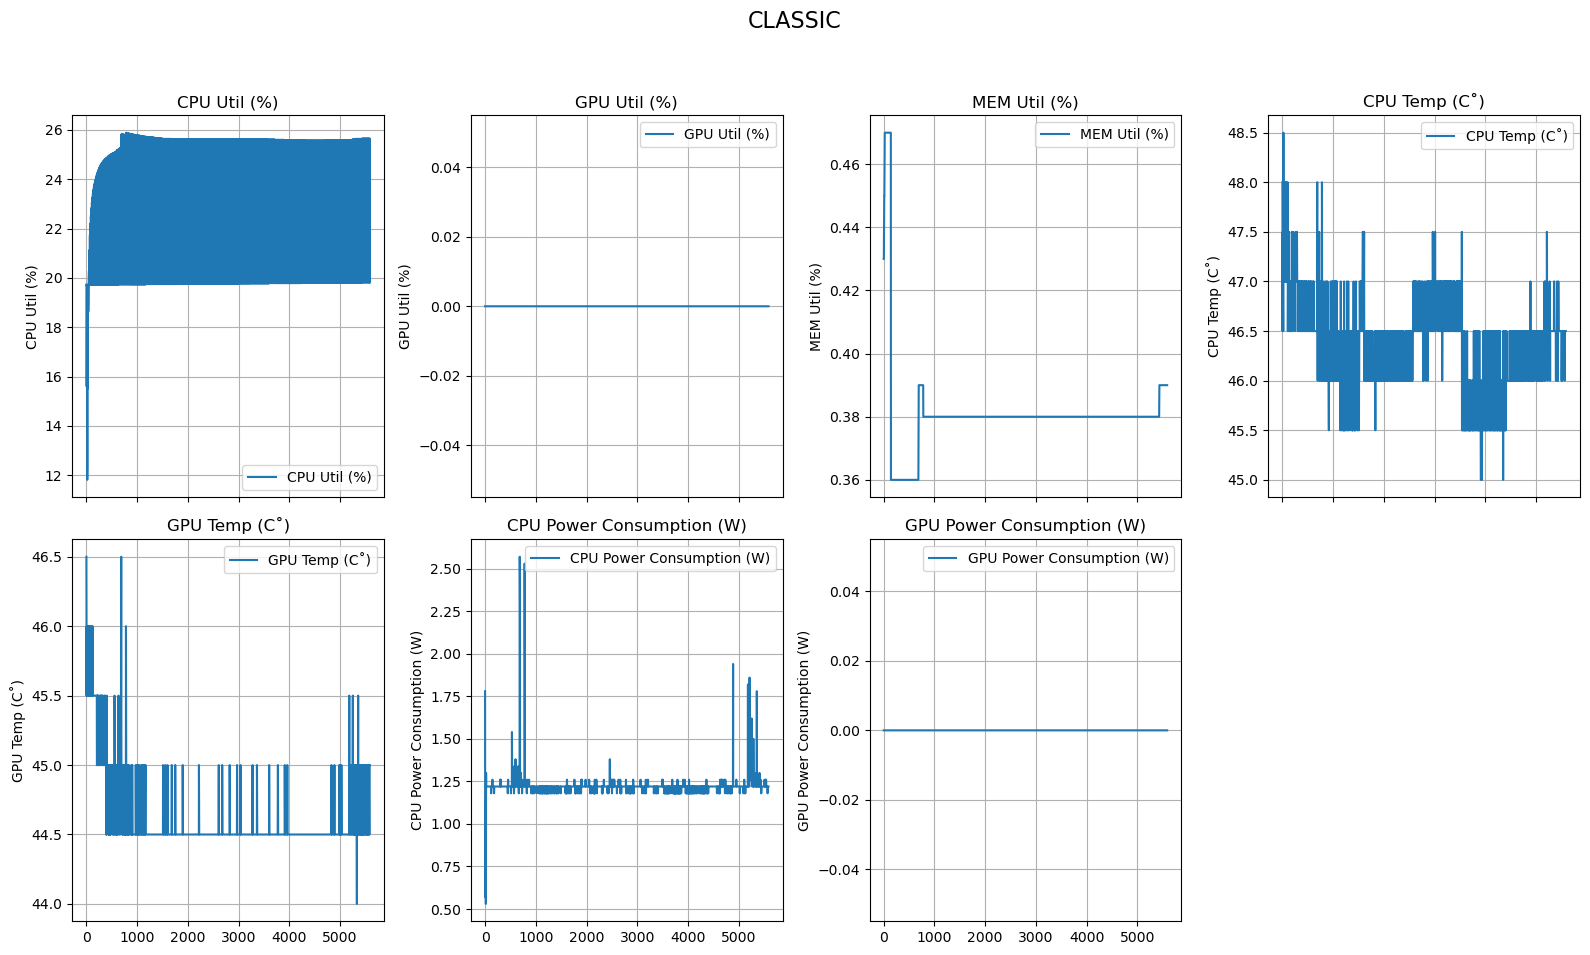

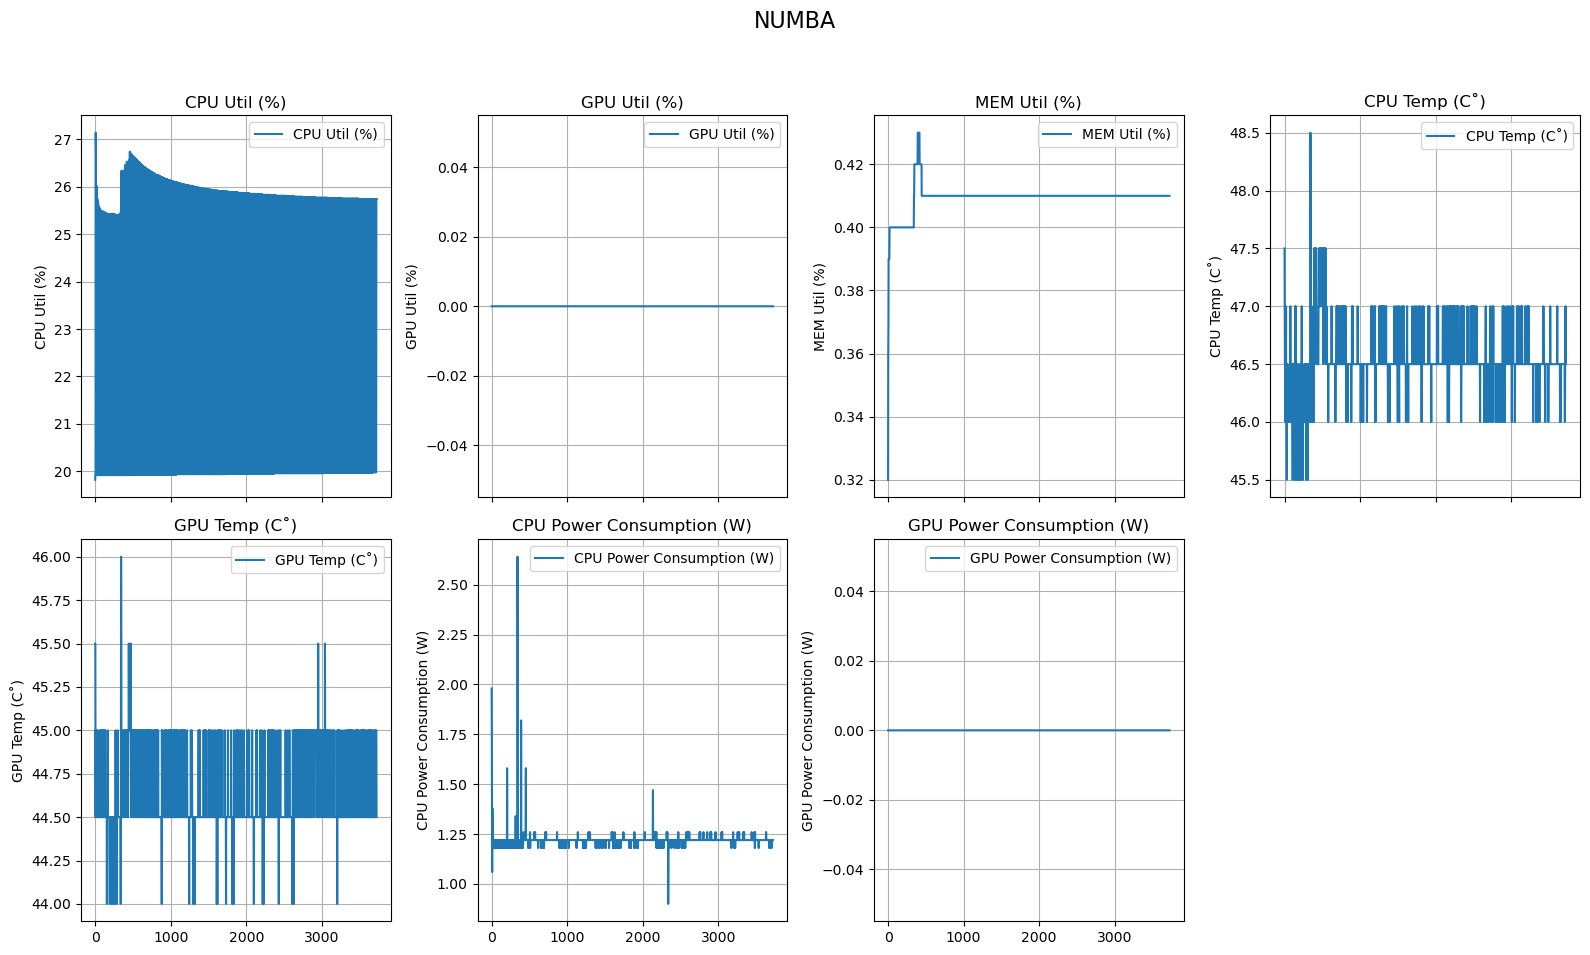

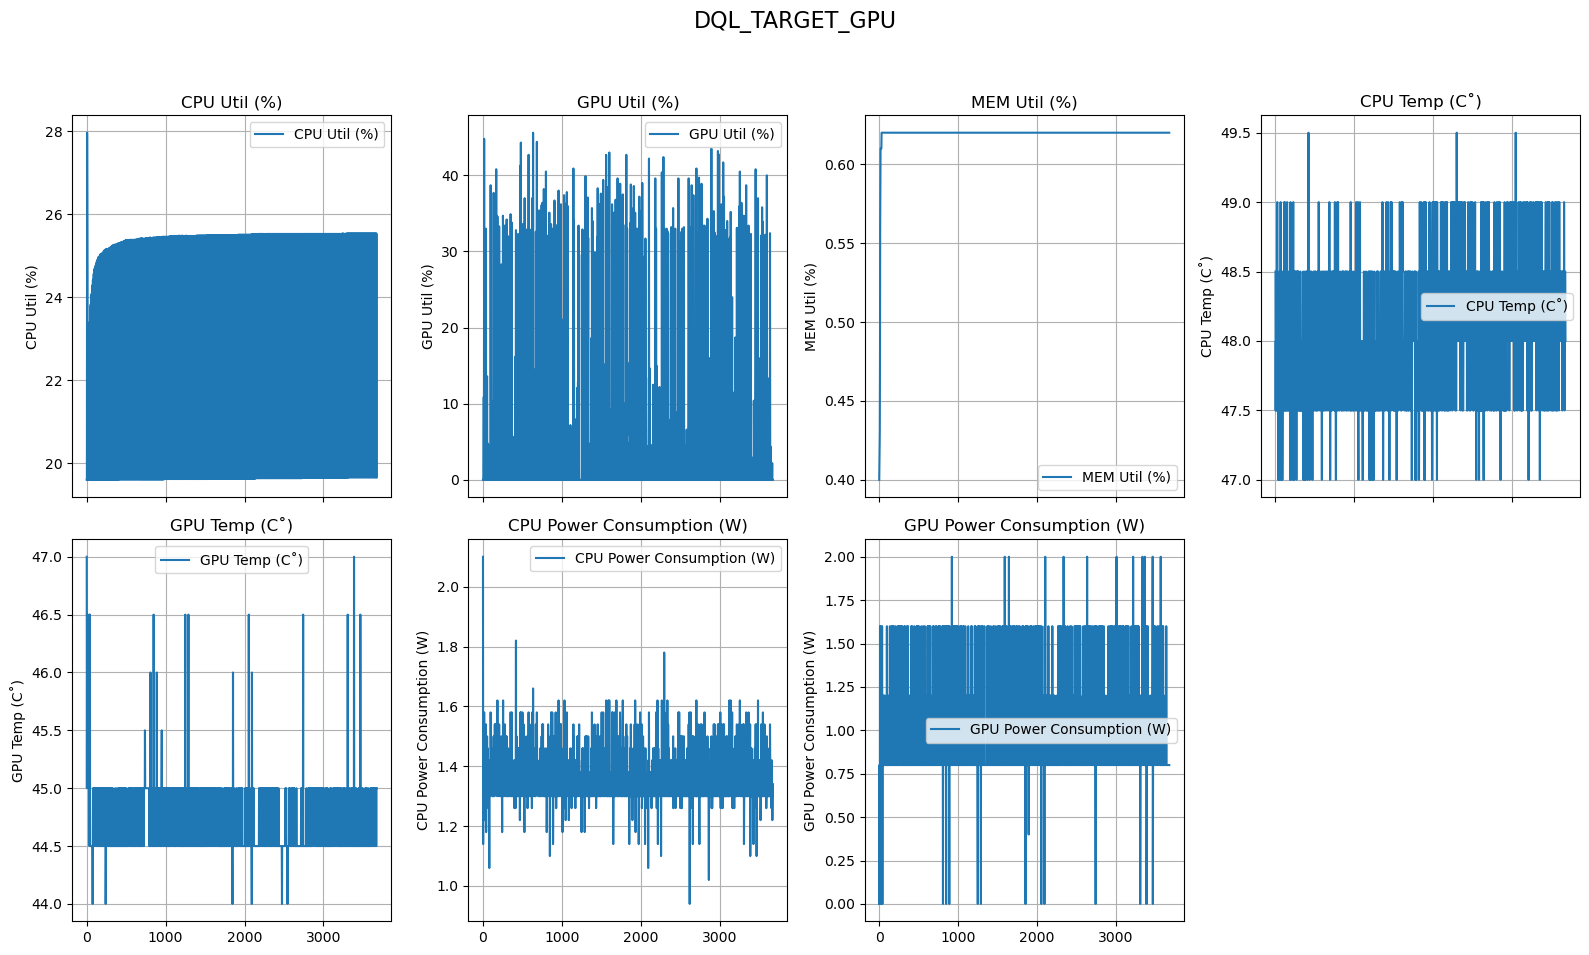

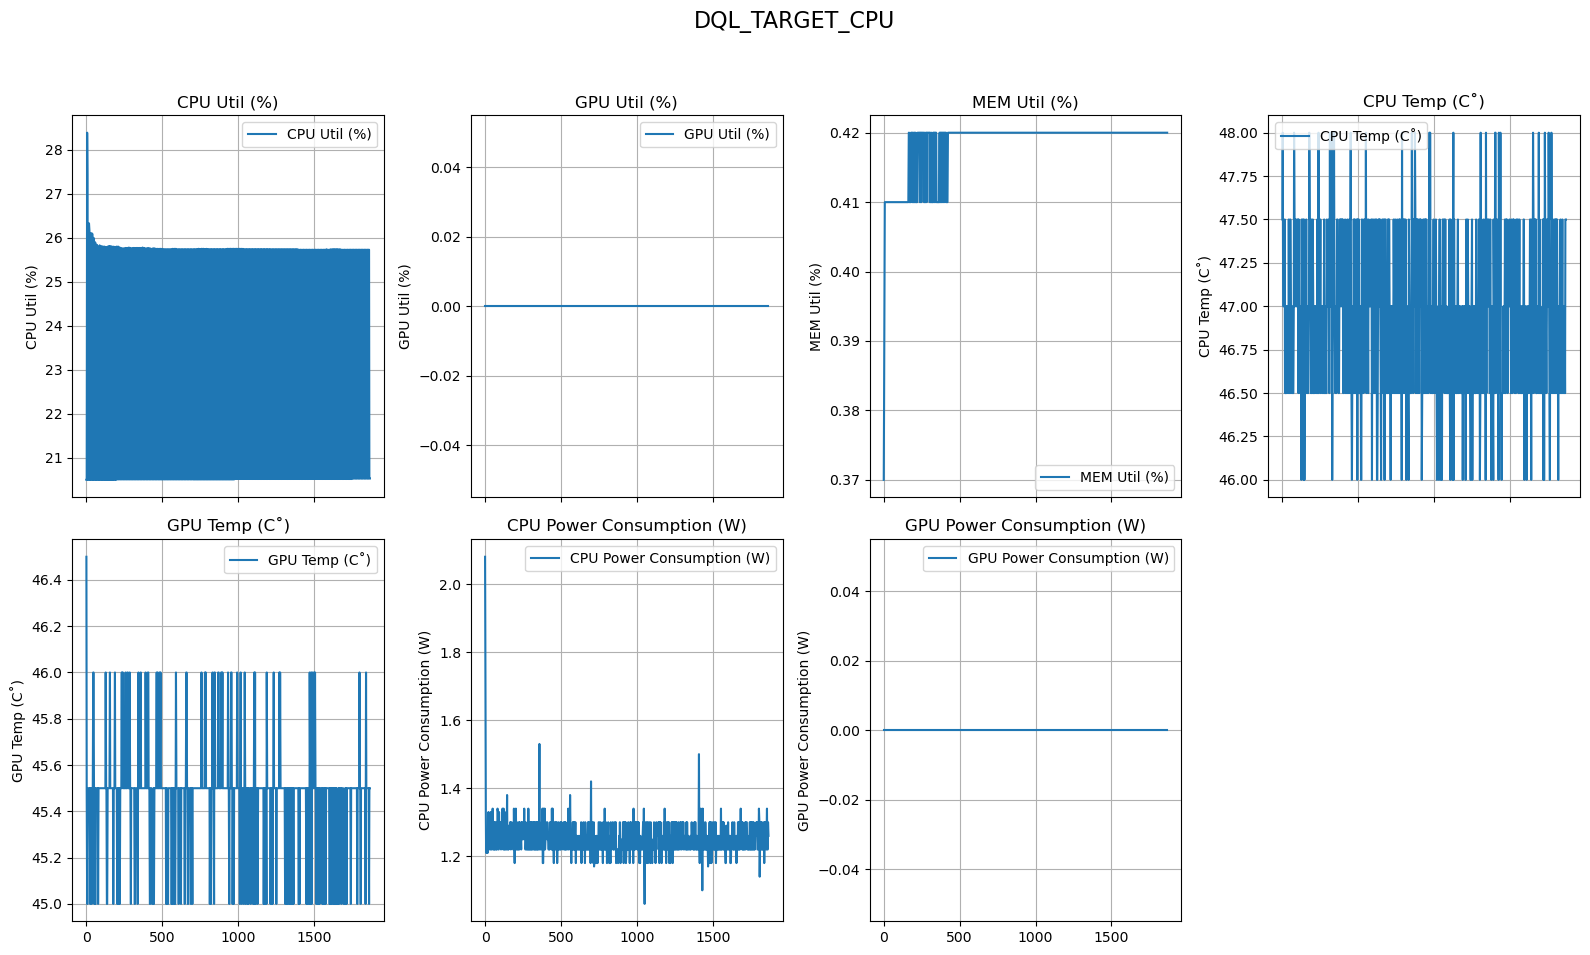

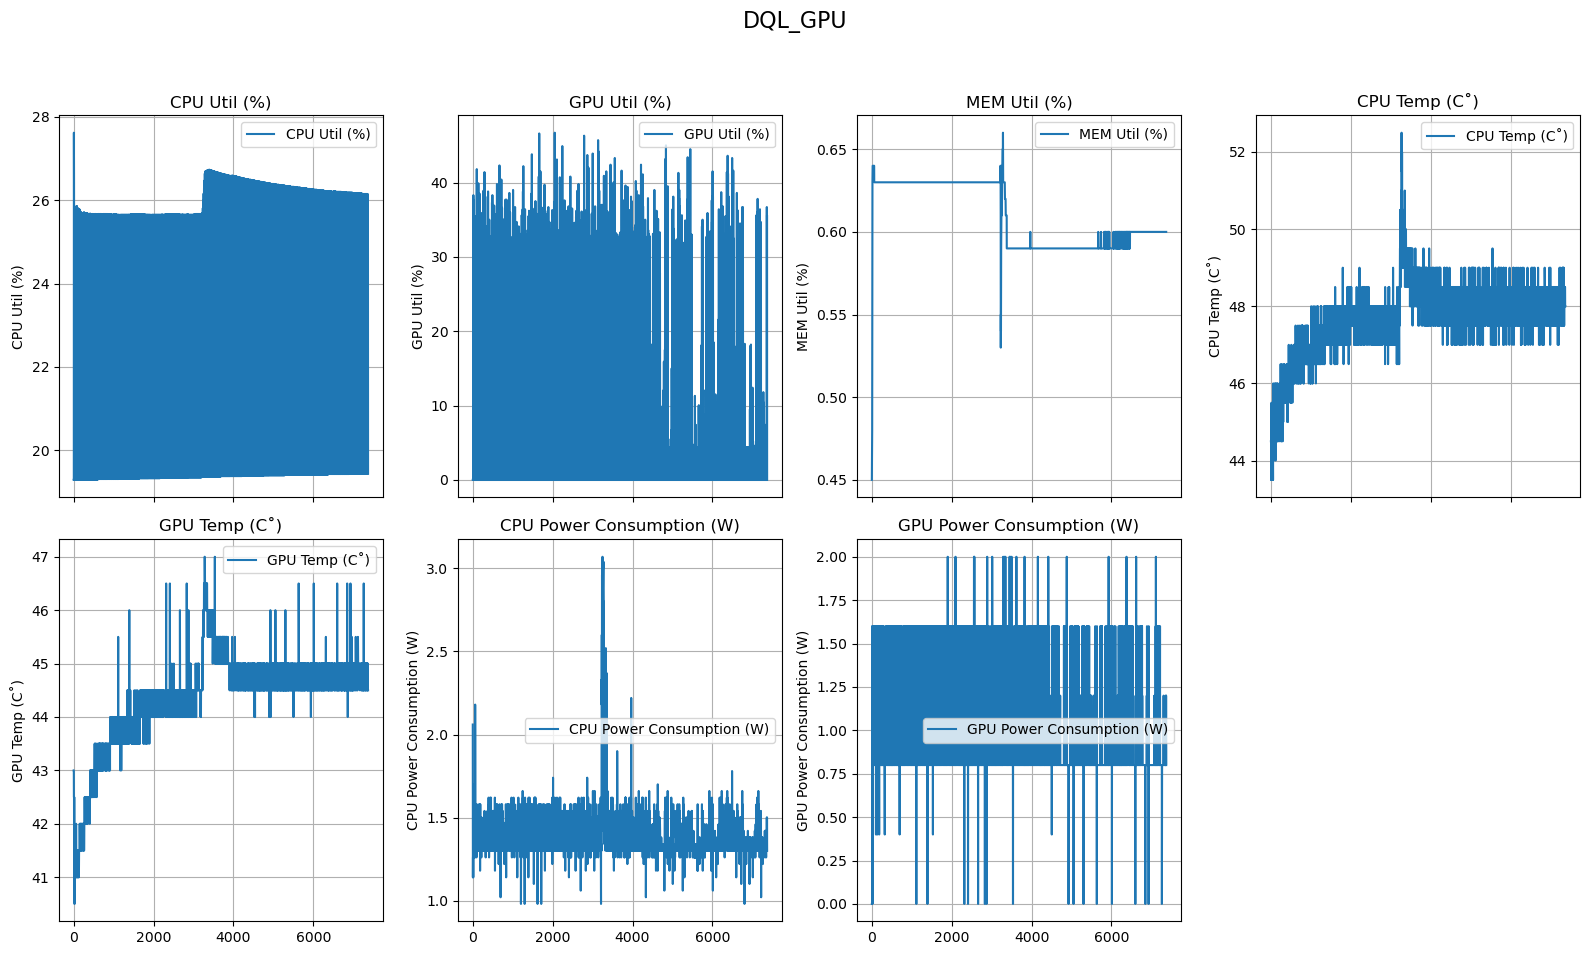

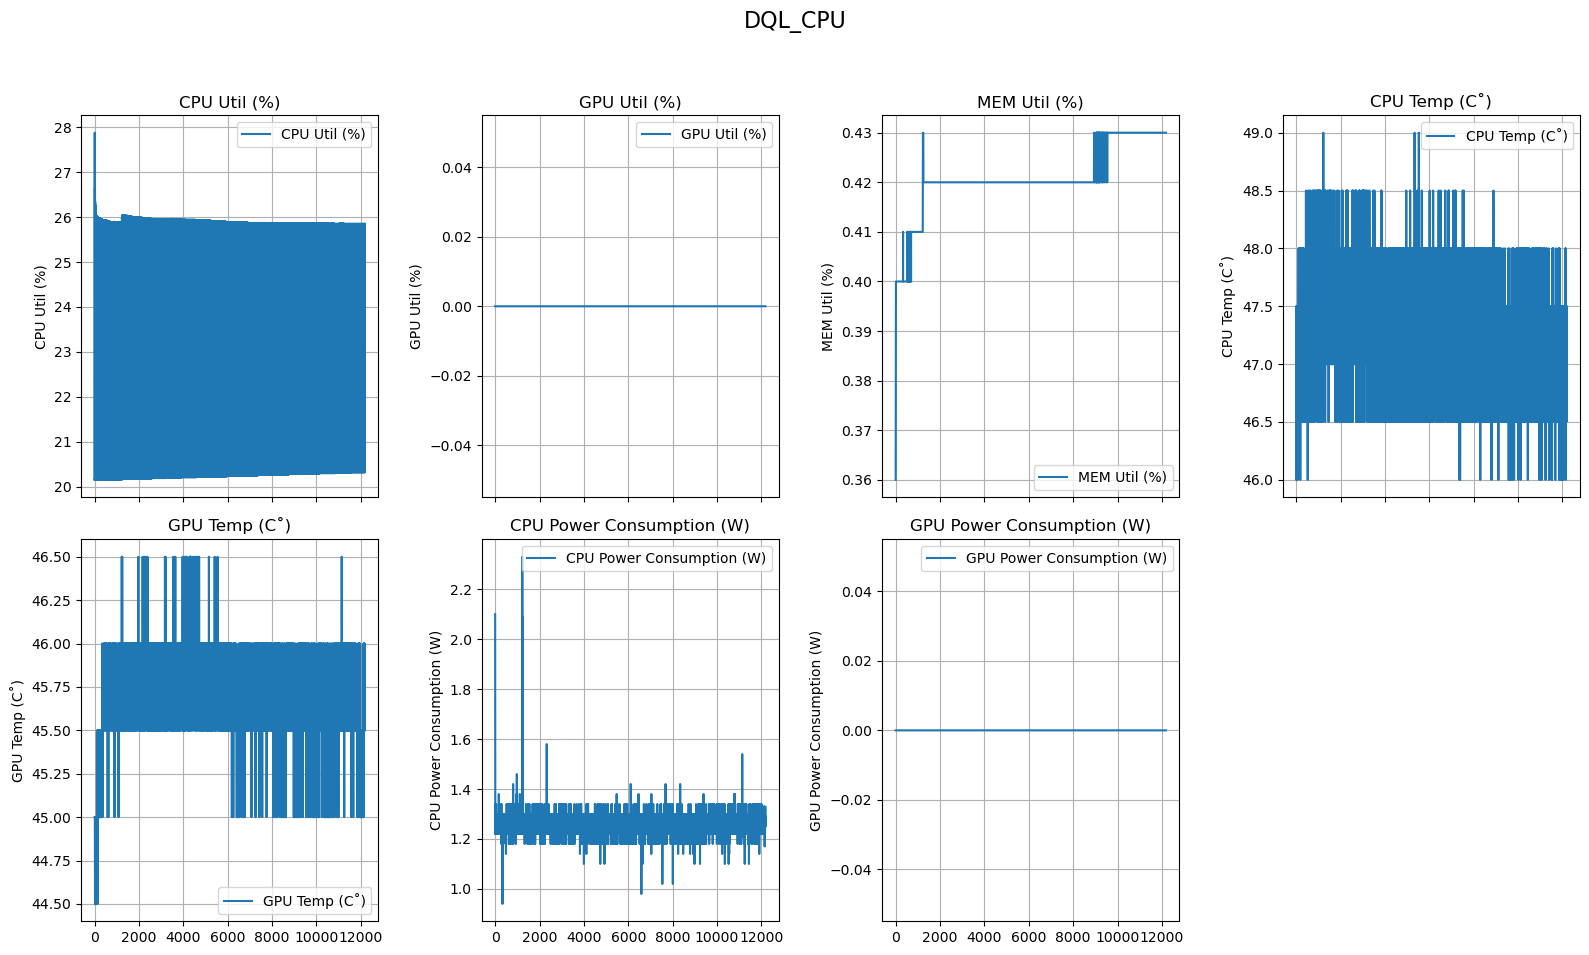

ML Server Execution Metrics


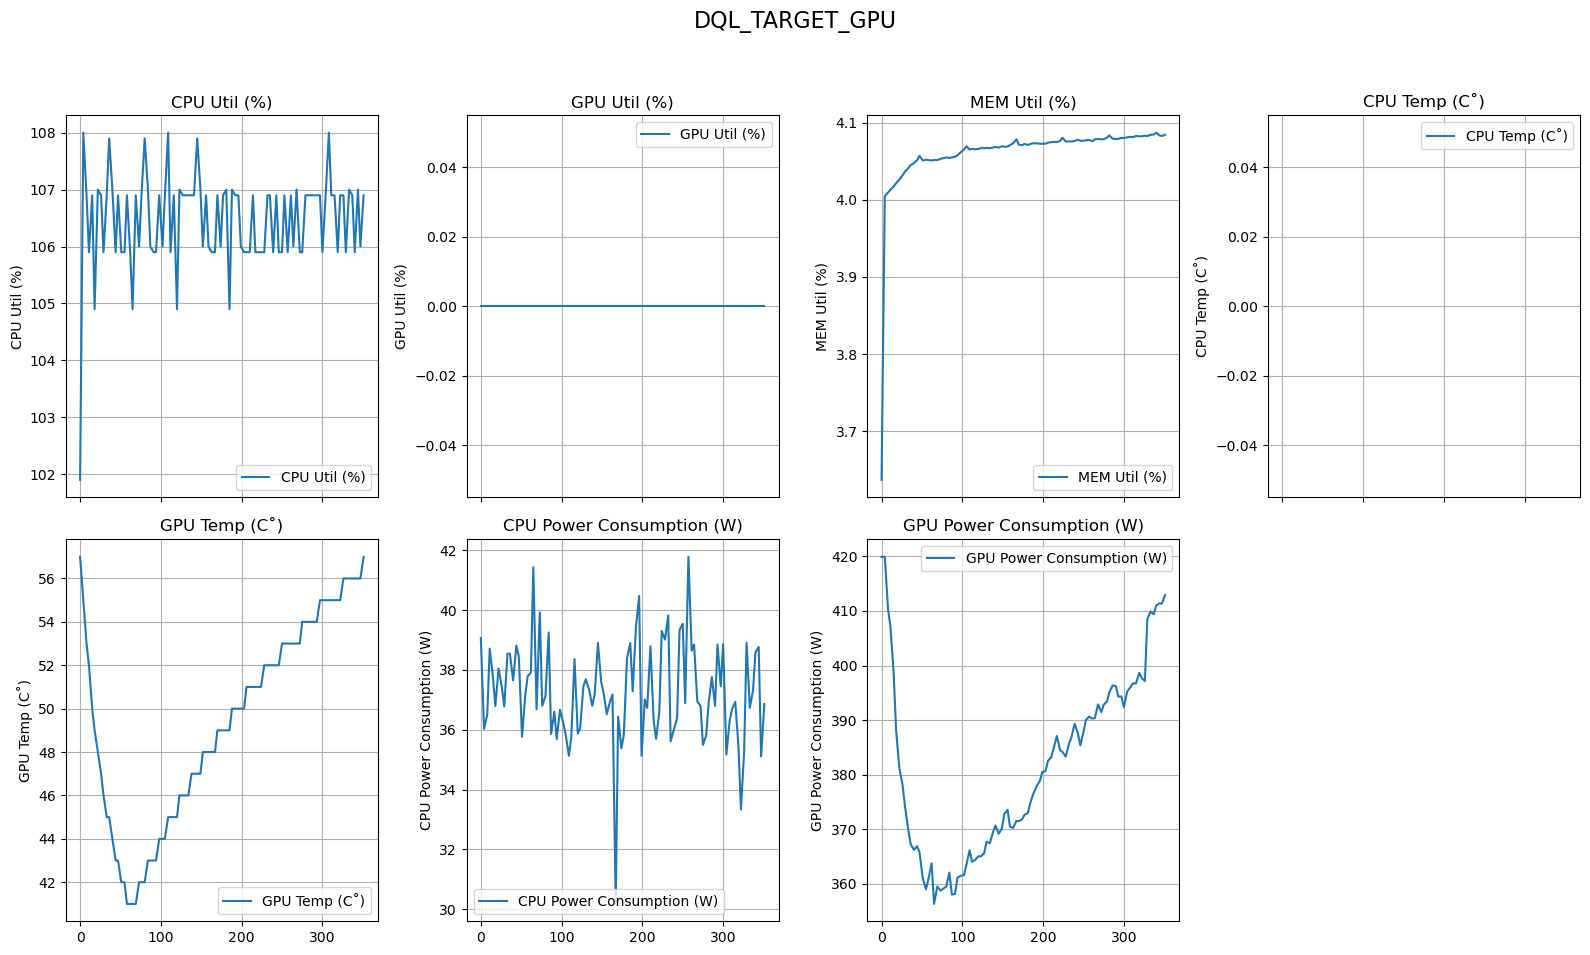

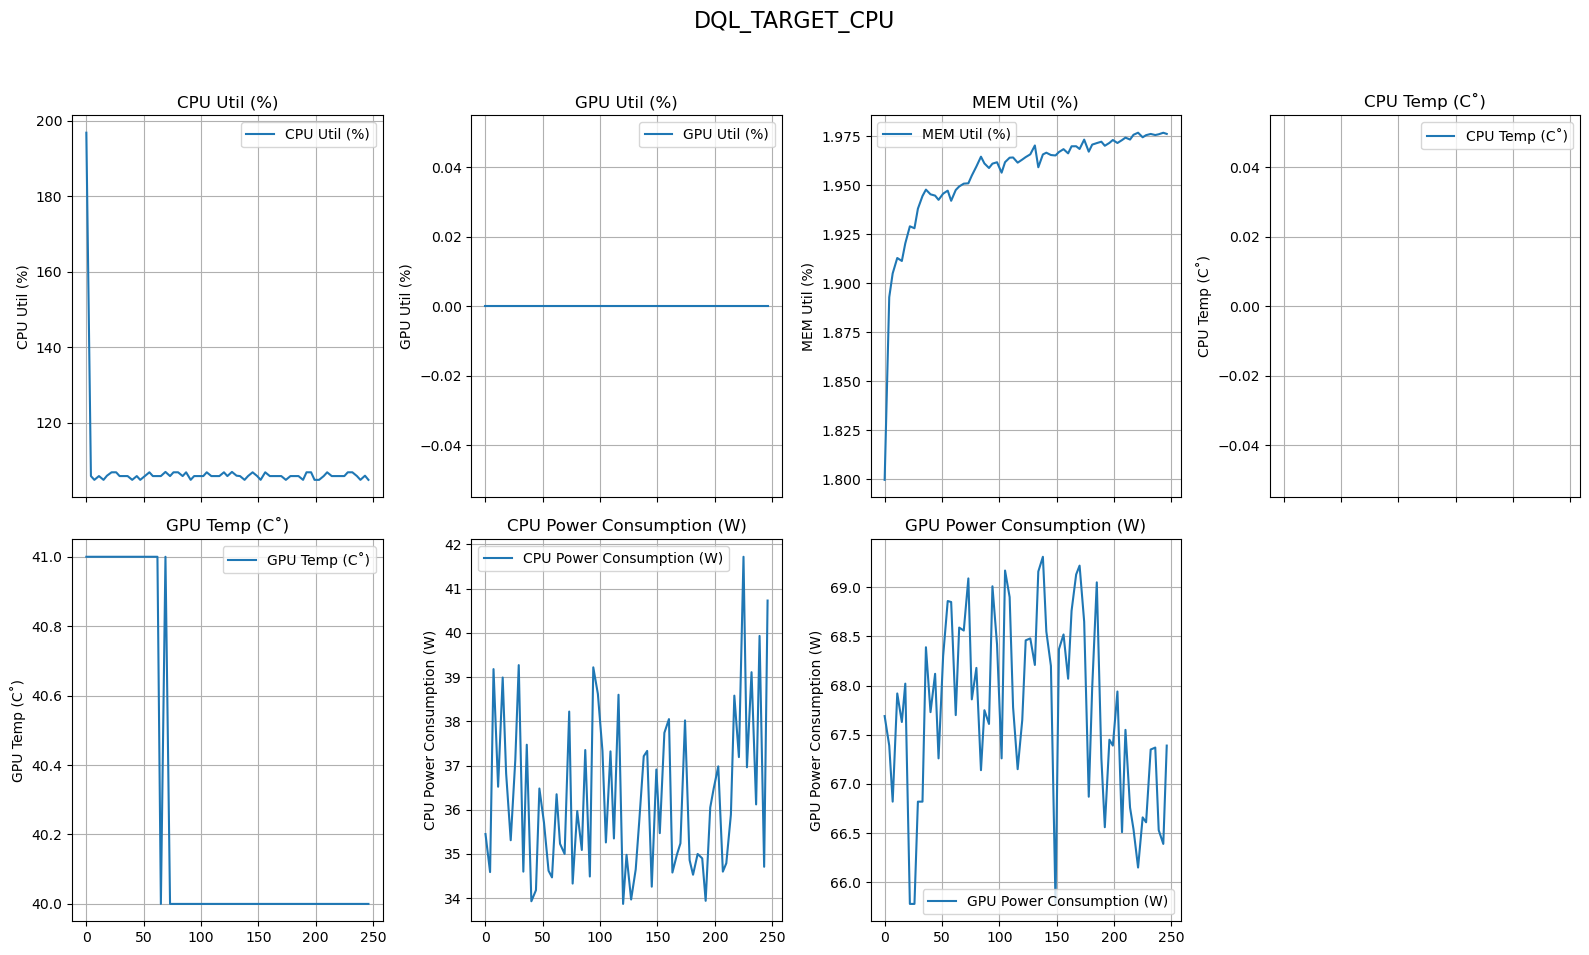

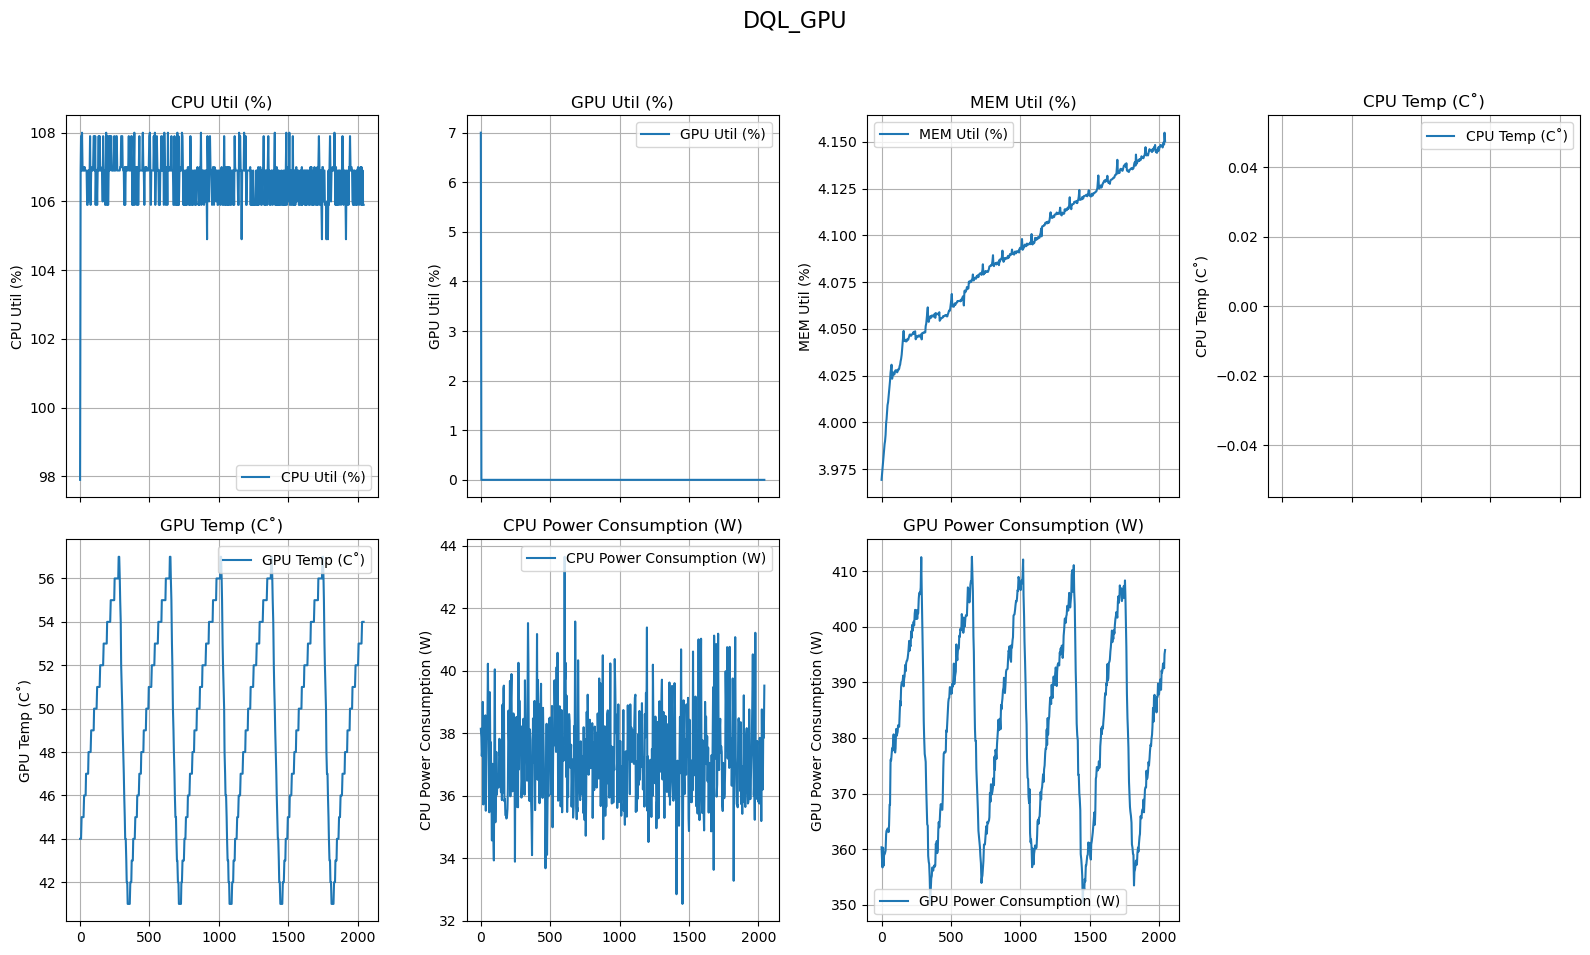

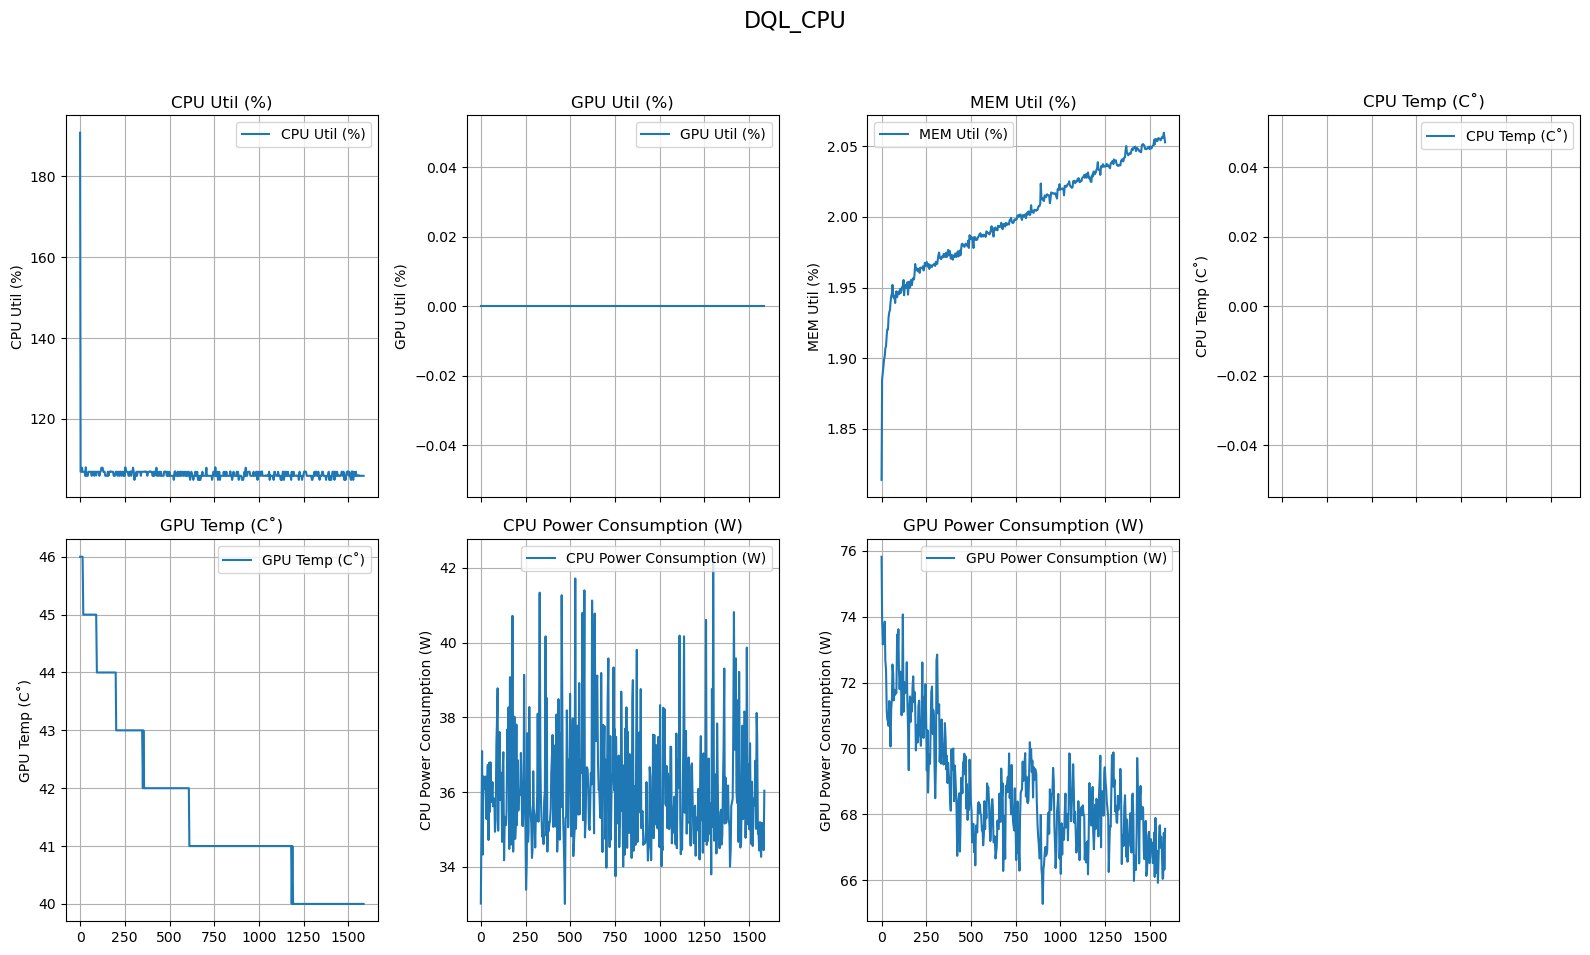

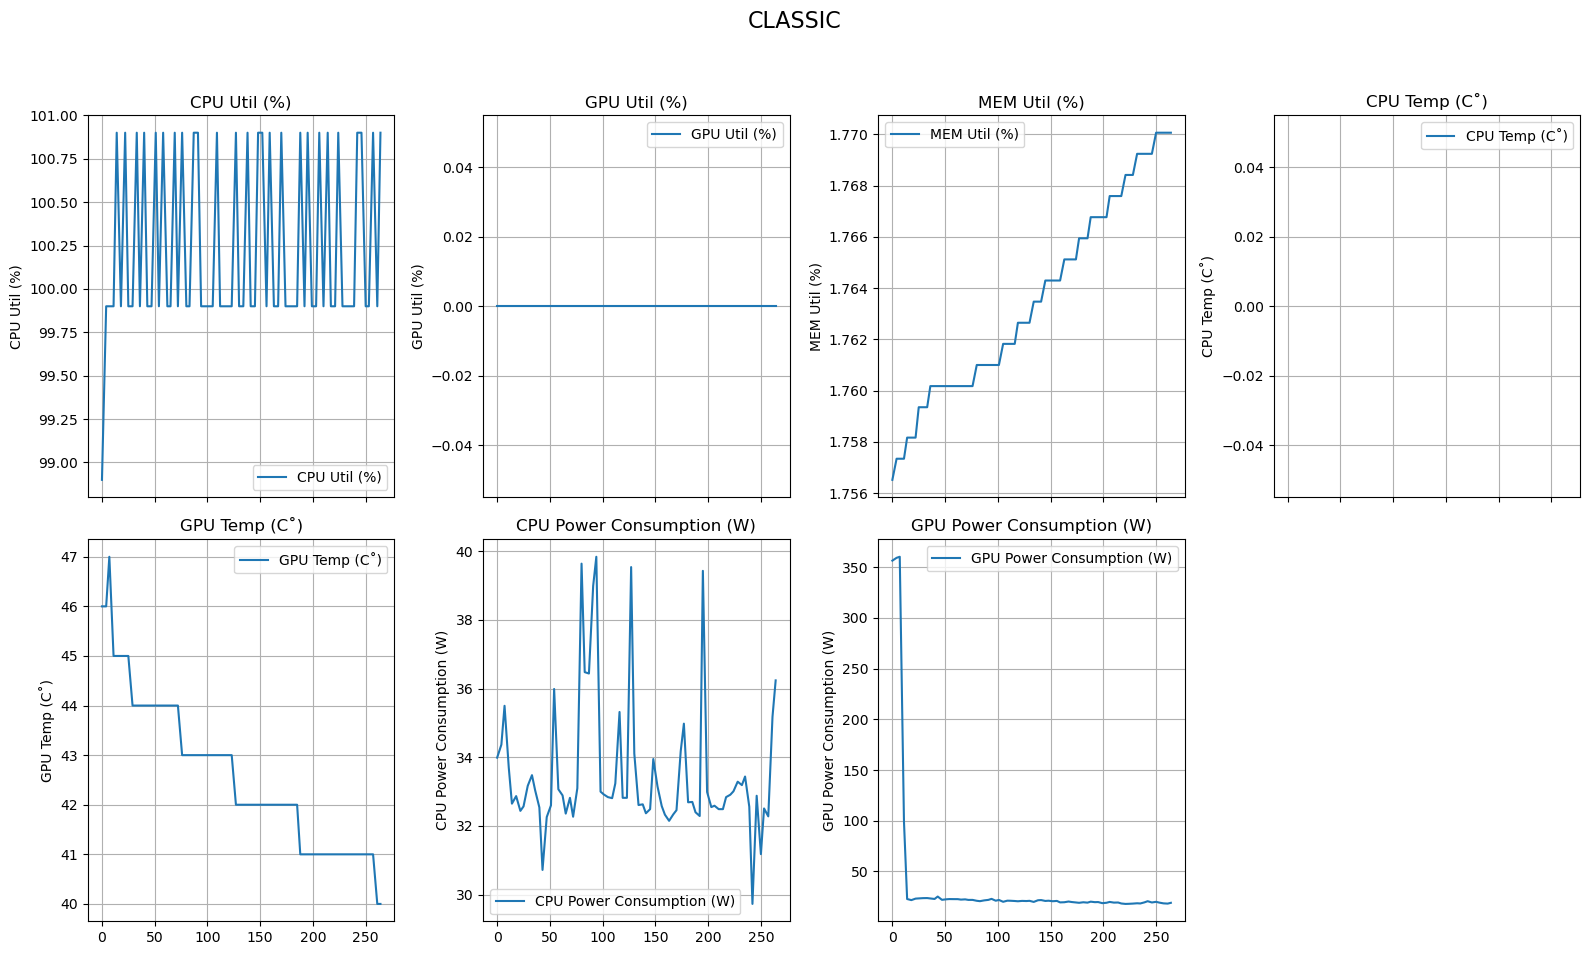

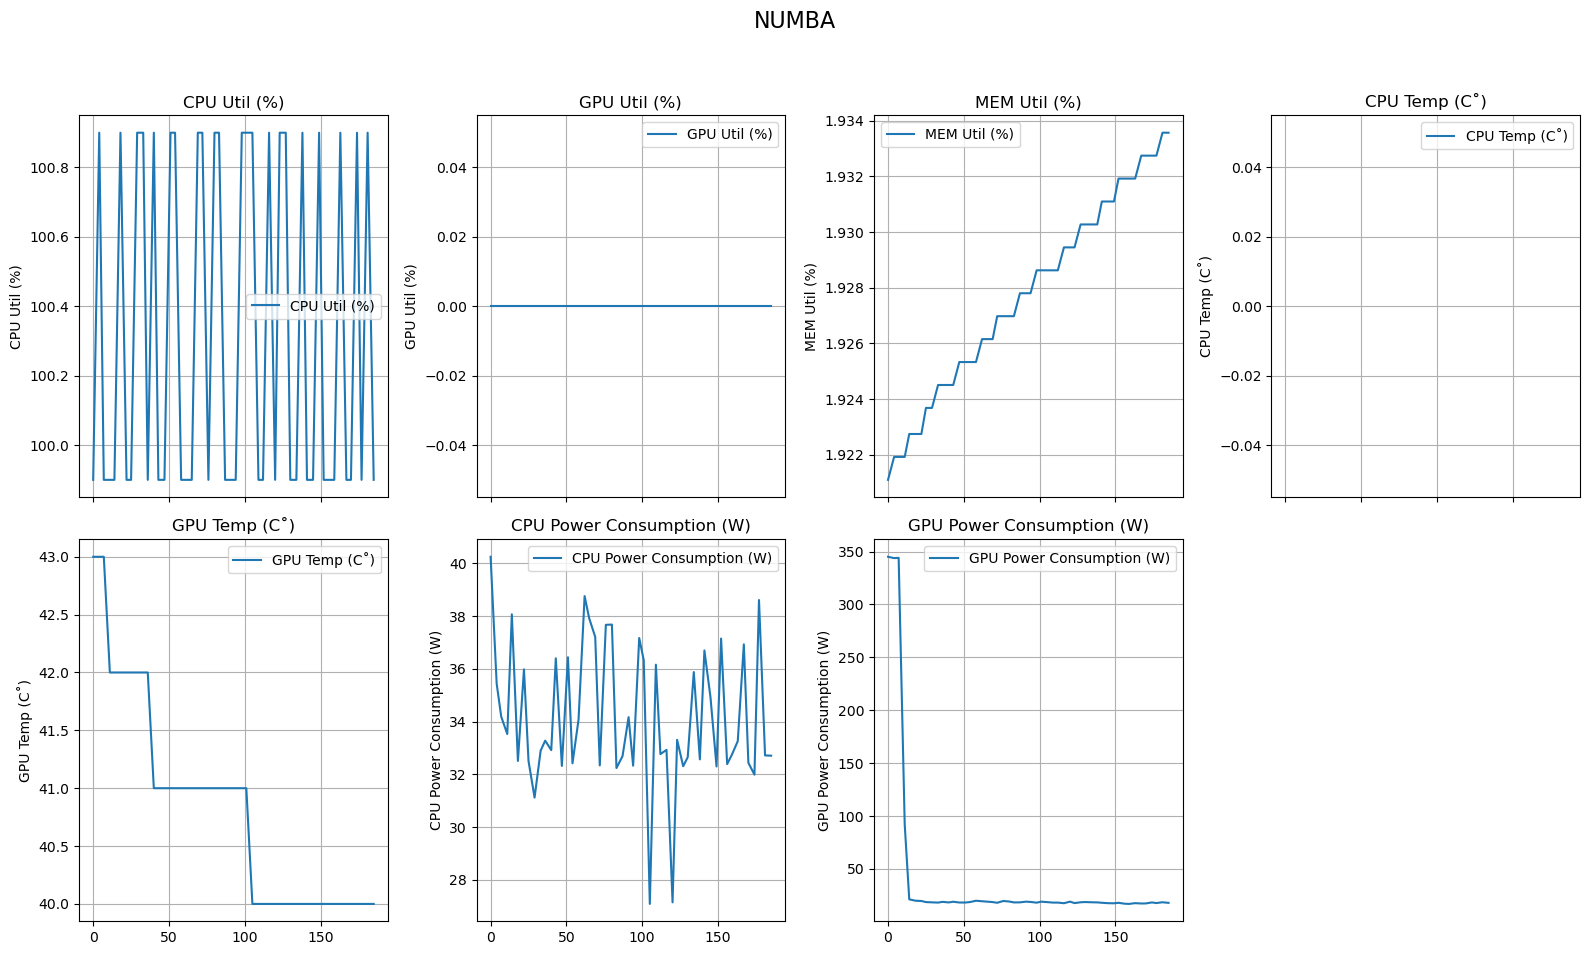

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict

metrics = {
    "CPU Util": "CPU Util (%)",
    "GPU Util": "GPU Util (%)",
    "MEM Util": "MEM Util (%)",
    "CPU Temp": "CPU Temp (C˚)",
    "GPU Temp": "GPU Temp (C˚)",
    "CPU Power Consumption": "CPU Power Consumption (W)",
    "GPU Power Consumption": "GPU Power Consumption (W)",
}

def plot_dataframes(dataframes: Dict[str, pd.DataFrame]):
    for training_type, df in dataframes.items():
        df["TimeDelta"] = pd.to_timedelta(df["Time"])
        min_time = df["TimeDelta"].min()
        df["TimeSinceFirst"] = df["TimeDelta"] - min_time
        df["TimeSinceFirstInSeconds"] = df["TimeSinceFirst"].dt.total_seconds()
        df["GPU Power Consumption"] = df["GPU Power Consumption"] * 10

        n_rows = 2
        n_cols = 4
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 10), sharex=True)
        fig.suptitle(training_type.upper(), fontsize=16)
        
        ax_list = axs.ravel()
        for ax in ax_list[len(metrics.keys()):]:
            ax.set_visible(False)

        for ax, (metric, description) in zip(ax_list, metrics.items()):
            if metric in df.columns:
                ax.plot(
                    df["TimeSinceFirstInSeconds"],
                    df[metric],
                    label=description,
                    linewidth=1.5,
                )
                ax.set_title(description)
                ax.set_ylabel(description)
                ax.grid(True)
                ax.legend()

        plt.xlabel("Time since first measurement (seconds)")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(f"./analysis/jetson/metrics/jetson-{training_type}.png")
        plt.show()

print("Jetson Execution Metrics")
plot_dataframes(jetson_dataframes)

print("ML Server Execution Metrics")
plot_dataframes(server_dataframes)

In [79]:
import numpy as np

def create_averages_df(dataframes: dict):
    average_dataframes = {}

    for training_type, df in dataframes.items():
        averages = {}
        
        for metric in metrics.keys():
            averages[f"{metrics[metric]} Avg."] = round(np.mean(df[metric]), 2)
        
        average_dataframes[training_type] = pd.DataFrame([averages], index=[training_type.capitalize()])
    return pd.concat(average_dataframes.values())


jetson_averages = create_averages_df(jetson_dataframes)
server_averages = create_averages_df(server_dataframes)

In [80]:
jetson_averages

,CPU Util (%) Avg.,GPU Util (%) Avg.,MEM Util (%) Avg.,CPU Temp (C˚) Avg.,GPU Temp (C˚) Avg.,CPU Power Consumption (W) Avg.,GPU Power Consumption (W) Avg.
Classic,22.59,0.00,0.38,46.34,44.61,1.22,0.00
Numba,22.93,0.00,0.41,46.52,44.64,1.22,0.00
Dql_target_gpu,22.53,6.28,0.62,48.06,44.71,1.36,0.96
Dql_target_cpu,23.13,0.00,0.42,46.92,45.46,1.25,0.00
Dql_gpu,22.71,7.83,0.61,47.68,44.36,1.39,0.98
Dql_cpu,23.07,0.00,0.42,47.24,45.66,1.26,0.00


In [81]:
server_averages

,CPU Util (%) Avg.,GPU Util (%) Avg.,MEM Util (%) Avg.,CPU Temp (C˚) Avg.,GPU Temp (C˚) Avg.,CPU Power Consumption (W) Avg.,GPU Power Consumption (W) Avg.
Dql_target_gpu,106.47,0.00,4.06,NaN,49.43,37.25,381.26
Dql_target_cpu,107.28,0.00,1.96,NaN,40.28,36.30,67.76
Dql_gpu,106.67,0.01,4.09,NaN,49.56,37.26,382.34
Dql_cpu,106.44,0.00,2.00,NaN,41.55,36.11,68.72
Classic,100.24,0.00,1.76,NaN,42.59,33.53,35.48
Numba,100.32,0.00,1.93,NaN,40.83,34.20,38.73


In [82]:
from typing import Dict

def get_execution_time(df: pd.DataFrame):
    df["TimeDelta"] = pd.to_timedelta(df["Time"])
    total_execution_time = df["TimeDelta"].max() - df["TimeDelta"].min()
    return total_execution_time

def calculate_training_times(dataframes: Dict[str, pd.DataFrame]):
    training_times = []

    for training_type, df in dataframes.items():
        execution_time = get_execution_time(df)
        training_times.append({'Training Type': training_type, 'Execution Time': execution_time})

    training_time_df = pd.DataFrame(training_times)
    
    training_time_df.set_index('Training Type', inplace=True)

    return training_time_df

jetson_training_times = calculate_training_times(jetson_dataframes)
server_training_times = calculate_training_times(server_dataframes)

In [83]:
jetson_training_times

,Execution Time
Training Type,
classic,0 days 01:33:08
numba,0 days 01:02:04
dql_target_gpu,0 days 01:01:16
dql_target_cpu,0 days 00:31:07
dql_gpu,0 days 02:02:50
dql_cpu,0 days 03:23:04


In [84]:
server_training_times

,Execution Time
Training Type,
dql_target_gpu,0 days 00:05:51
dql_target_cpu,0 days 00:04:06
dql_gpu,0 days 00:34:03
dql_cpu,0 days 00:26:25
classic,0 days 00:04:24
numba,0 days 00:03:05


In [85]:
def performance_per_watt(df: pd.DataFrame, pwr_consumption_metric: str, total_episodes: int):
    avg_pwr = df[pwr_consumption_metric].mean()
    train_time_hrs = get_execution_time(df).total_seconds() / 3600
    total_energy_consumed = avg_pwr * train_time_hrs
    
    return total_episodes / total_energy_consumed

In [86]:
pwr_consumption_metrics = [
    "CPU Power Consumption",
    "GPU Power Consumption"
]

df_targets_epochs = {
    "classic": 15000,
    "numba": 15000,
    "dql_gpu": 1000,
    "dql_cpu": 1000,
    "dql_target_gpu": 100,
    "dql_target_cpu": 100
}

def get_performance_results(df_dict: dict):
    result_dict = {}
    for target in df_targets_epochs.keys():
        pwr_consumptions = {}
        for pwr_consumption_metric in pwr_consumption_metrics:
            tasks_per_watt_hour = round(performance_per_watt(df_dict[target], pwr_consumption_metric, df_targets_epochs[target]), 2)
            pwr_consumptions[f"{pwr_consumption_metric.split(' ')[0]} Performance per Watt"] = tasks_per_watt_hour if not np.isinf(tasks_per_watt_hour) else "N/A"
        result_dict[target] = pwr_consumptions
    return result_dict
    
jetson_watt_hour_results = get_performance_results(jetson_dataframes)
server_watt_hour_results = get_performance_results(server_dataframes)

/var/folders/fh/lm059lvn1z90mq84wv1b6_rc0000gn/T/ipykernel_90849/1967067192.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return total_episodes / total_energy_consumed


In [87]:
jetson_watt_hour_results

{'classic': {'CPU Performance per Watt': 7915.26,
  'GPU Performance per Watt': 'N/A'},
 'numba': {'CPU Performance per Watt': 11879.74,
  'GPU Performance per Watt': 'N/A'},
 'dql_gpu': {'CPU Performance per Watt': 352.6,
  'GPU Performance per Watt': 496.49},
 'dql_cpu': {'CPU Performance per Watt': 235.32,
  'GPU Performance per Watt': 'N/A'},
 'dql_target_gpu': {'CPU Performance per Watt': 72.11,
  'GPU Performance per Watt': 102.22},
 'dql_target_cpu': {'CPU Performance per Watt': 154.05,
  'GPU Performance per Watt': 'N/A'}}

In [88]:
server_watt_hour_results

{'classic': {'CPU Performance per Watt': 6100.2,
  'GPU Performance per Watt': 5765.16},
 'numba': {'CPU Performance per Watt': 8534.13,
  'GPU Performance per Watt': 7537.07},
 'dql_gpu': {'CPU Performance per Watt': 47.29,
  'GPU Performance per Watt': 4.61},
 'dql_cpu': {'CPU Performance per Watt': 62.9,
  'GPU Performance per Watt': 33.05},
 'dql_target_gpu': {'CPU Performance per Watt': 27.53,
  'GPU Performance per Watt': 2.69},
 'dql_target_cpu': {'CPU Performance per Watt': 40.32,
  'GPU Performance per Watt': 21.6}}